# Classification of NBA players role

## IMPORTANT: make sure to rerun all the code from the beginning to obtain the results for the final version of your notebook, since this is the way we will do it before evaluting your notebook! Only the notebook file will be submitted, do not change the data filenames, file content or paths we'll use the provided ones.

Student name: Andrea Nicolai
ID Number: 1233407

### Dataset description

We will be working with a dataset of NBA basketball players data (you can get from https://www.kaggle.com/jacobbaruch/nba-player-of-the-week the full dataset).

The provided data is a subset of the full dataset containing the players that have the role of Center and of Point Guard. For each player the dataset contains the height, weight and age.

From Wikipedia:

The **Center** (C), also known as the five, or the big man, is one of the five positions in a regular basketball game. The center is normally the tallest player on the team, and often has a great deal of strength and body mass as well. In the NBA, the center is usually 6' 10" (2.08 m) or taller and usually weighs 240 lbs (109 kg) or more. 

**Point Guards** (PG, a.k.a. as "play maker") are expected to run the team's offense by controlling the ball and making sure that it gets to the right players at the right time. In the NBA, point guards are usually about 6' 3" (1.93 m) or shorter, and average about 6' 2" (1.88 m). Having above-average size (height, muscle) is considered advantageous, although size is secondary to situational awareness, speed, quickness, and ball handling skills. Shorter players tend to be better dribblers since they are closer to the floor, and thus have better control of the ball while dribbling. 


As it is clear from the description, the height and weight of the player are good hints to predict their role and in this lab we will exploit this features to estimate the role.


### Three features (regressors) are considered for this dataset:


1) Height in cm

2) Weight in kg

3) Age in years

We first import all the packages that are needed.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import csv

import numpy as np
import scipy as sp
import sklearn as sl
from scipy import stats
from sklearn import datasets
from sklearn import linear_model

# Perceptron
We will implement the perceptron algorithm and use it to learn a halfspace.

**TO DO** Set the random seed (you can use your ID (matricola) or any other number!).

In [2]:
IDnumber = 123 #try also to change the seed to see the impact of random initialization on the results
np.random.seed(IDnumber)

Load the dataset and then split in training set and test set (the training set is typically larger, you can use a 75% tranining 25% test split) after applying a random permutation to the datset.

A) Load dataset and perform permutation

In [3]:
#load the dataset
filename = 'data/NBA.csv' # do not change the file name or content
NBA = csv.reader(open(filename, newline=''), delimiter=',')

header = next(NBA) #skip first line
print(header)

dataset = list(NBA)
for i in range(len(dataset)):
    dataset[i] = [int(x) for x in dataset[i]]
    
dataset = np.asarray(dataset)

X = dataset[:,1:4] #columns 1,2,3 contain the features
Y = dataset[:,0]  # column 0: labels

Y = Y*2-1  # set labels to -1, 1 as required by perceptron implementation

m = dataset.shape[0]
permutation = np.random.permutation(m) # random permurtation

X = X[permutation]
Y = Y[permutation]


['Position', 'Height cm', 'kg', 'Age']


We are going to classify class "1" (Center) vs class "-1" (Point Guard)

B) **TO DO** Divide the data into training set and test set (3/4 of the data in the first set, 1/4 in the second one)

In [4]:
#Divide in training and test: make sure that your training set
#contains at least 10 elements from class 1 and at least 10 elements
#from class -1! If it does not, modify the code so to apply more random
#permutations (or the same permutation multiple times) until this happens.
#IMPORTANT: do not change the random seed.

#m_training needs to be the number of samples in the training set
m_training = int((3/4)*len(X))

#m_test needs to be the number of samples in the test set
m_test = int((1/4)*len(X))

#X_training = instances for training set
X_training = X[:m_training]
#Y_training = labels for the training set
Y_training = Y[:m_training]


while((np.count_nonzero(Y_training == 1) < 11 )):
    permutation = np.random.permutation(m)
    m = dataset.shape[0]
    permutation = np.random.permutation(m) # random permutation
    X = X[permutation]
    Y = Y[permutation]
    X_training = X[:m_training]
    Y_training = Y[:m_training]
    print("Permutation!")
    
#X_test = instances for test set
X_test = X[m_training::]
#Y_test = labels for the test set
Y_test = Y[m_training::]

print(Y_training) #to make sure that Y_training contains both 1 and -1
print(m_test)

print("Shape of training set: " + str(X_training.shape))
print("Shape of test set: " + str(X_test.shape))

[ 1  1 -1 -1 -1 -1 -1  1  1  1 -1 -1 -1  1  1 -1  1  1 -1 -1  1  1  1  1
  1  1  1  1 -1 -1 -1  1 -1  1  1  1  1 -1  1  1  1 -1 -1  1  1  1  1 -1
 -1 -1 -1  1 -1  1 -1 -1 -1  1 -1 -1  1  1 -1 -1 -1 -1 -1  1  1 -1  1 -1
  1  1  1  1  1  1  1  1 -1 -1 -1  1  1 -1  1 -1  1 -1 -1 -1  1  1  1 -1
  1 -1 -1 -1 -1  1  1 -1  1 -1  1 -1  1 -1 -1  1  1 -1  1  1  1  1  1  1
  1 -1 -1  1 -1 -1 -1  1 -1 -1  1  1  1  1 -1 -1  1  1  1 -1  1 -1 -1  1
 -1 -1  1 -1  1 -1  1  1 -1  1  1 -1  1  1  1 -1 -1 -1 -1 -1  1 -1 -1 -1
  1 -1  1  1  1  1 -1  1 -1 -1 -1  1  1 -1  1 -1  1  1  1 -1  1 -1 -1 -1
  1  1  1]
65
Shape of training set: (195, 3)
Shape of test set: (65, 3)


**TO DO** Now add a 1 in front of each sample so that we can use a vector in homogeneous coordinates to describe all the coefficients of the model. You can use the function $hstack$ in $numpy$

In [5]:
#add a 1 to each sample (homogeneous coordinates)

bias_train = np.ones(( m_training, 1))
if X_training.shape == ( m_training , 3):
    X_training = np.hstack((bias_train, X_training))

**TO DO** Now complete the function *perceptron*. Since the perceptron does not terminate if the data is not linearly separable, your implementation should return the desired output (see below) if it reached the termination condition seen in class or if a maximum number of iterations have already been run, where one iteration corresponds to one update of the perceptron weights. In case the termination is reached because the maximum number of iterations have been completed, the implementation should return **the best model** seen up to now.

The input parameters to pass are:
- $X$: the matrix of input features, one row for each sample
- $Y$: the vector of labels for the input features matrix X
- $max\_num\_iterations$: the maximum number of iterations for running the perceptron

The output values are:
- $best\_w$: the vector with the coefficients of the best model
- $best\_error$: the *fraction* of missclassified samples for the best model

In [6]:
def perceptron(X, Y, max_num_iterations):
    
    #initialize
    best_w = np.zeros((np.size(X,1)))
    temp_w = np.zeros((np.size(X,1)))
    array_errs = []
    error = 0
    iterations = 0
    
    #check for misclassified with initialization values, can be avoided
    #since all weights are 0's and whole training set will be considered as misclassified
    for k in range(m_training):
        if ( (Y[k]*np.dot(X[k],best_w) ) <= 0 ):
            array_errs.append(k)
    best_error = len(array_errs)/m_training
    
    #for now best_w is all zeros
    #and best_errs are misclassified examples using it  
    #real perceptron
    for iterations in range(max_num_iterations):
        index = np.random.choice(array_errs) #draw from misclassified ones
        temp_w += Y[index]*X[index]          #then update the temp_w (1 iteration)
        array_errs = []
        
        for k in range(m_training): #check for errors in whole training dataset with sol
            if ( (Y[k]*np.dot(X[k],temp_w)) <= 0 ): #this is a missclassification
                array_errs.append(k)
        error = len(array_errs)/m_training
        
        if (error == 0): 
            print("Optimal solution found!")
            best_w = temp_w 
            best_error = error
            break
            
        if (error < best_error):
            best_w = temp_w #if it is smaller then update best_w and best_err
            best_error = error
    
    return best_w, best_error

Now we use the implementation above of the perceptron to learn a model from the training data using 100 iterations and print the error of the best model we have found.

In [7]:
#now run the perceptron for 100 iterations
w_found, error = perceptron(X_training,Y_training, 100)
print("Best solution is: " , w_found)
print("Training Error of perceptron (100 iterations): " + str(error))

Best solution is:  [  -6. -260.  639. -180.]
Training Error of perceptron (100 iterations): 0.08205128205128205


**TO DO** use the best model $w\_found$ to predict the labels for the test dataset and print the fraction of missclassified samples in the test set (the test error that is an estimate of the true loss).

In [8]:
#now use the w_found to make predictions on test dataset

num_errors = 0

# PLACE YOUR CODE to compute the number of errors

bias_test = np.ones(( m_test, 1))
if X_test.shape == ( m_test , 3):
    X_test = np.hstack((bias_test, X_test))

for i in range(m_test):
    if (Y_test[i]*np.dot(X_test[i],w_found)) <= 0:
        num_errors += 1

true_loss_estimate = num_errors/m_test  # error rate on the test set

#NOTE: you can avoid using num_errors if you prefer, as long as true_loss_estimate is correct
print("Test Error of perceptron (100 iterations): " + str(true_loss_estimate))

Test Error of perceptron (100 iterations): 0.23076923076923078


In [9]:
num_errors = 0
error = 0
iteration = 100
tr_errors = []
ts_errors = []

for i in range(iteration):
    w_found, error = perceptron(X_training,Y_training, 100)
    print("Best solution is: " , w_found)
    print(i+1 , " RUN: Training Error of perceptron (100 iterations): " + str(error))
    for k in range(m_test):
         if (Y_test[k]*np.dot(X_test[k],w_found)) <= 0:
                num_errors += 1
    true_loss_estimate = num_errors/m_test  # error rate on the test set
    print(i+1 , " RUN: Test Error of perceptron (100 iterations): " + str(true_loss_estimate), "\n")
    tr_errors.append(error)
    ts_errors.append(true_loss_estimate)
    num_errors, error = 0, 0

Best solution is:  [  -6. -433.  778. -136.]
1  RUN: Training Error of perceptron (100 iterations): 0.08717948717948718
1  RUN: Test Error of perceptron (100 iterations): 0.26153846153846155 

Best solution is:  [  -6. -377.  842. -137.]
2  RUN: Training Error of perceptron (100 iterations): 0.08205128205128205
2  RUN: Test Error of perceptron (100 iterations): 0.18461538461538463 

Best solution is:  [  -6. -426.  781. -127.]
3  RUN: Training Error of perceptron (100 iterations): 0.08205128205128205
3  RUN: Test Error of perceptron (100 iterations): 0.23076923076923078 

Best solution is:  [  -6. -340.  717. -159.]
4  RUN: Training Error of perceptron (100 iterations): 0.08717948717948718
4  RUN: Test Error of perceptron (100 iterations): 0.06153846153846154 

Best solution is:  [  -6. -242.  736. -142.]
5  RUN: Training Error of perceptron (100 iterations): 0.08205128205128205
5  RUN: Test Error of perceptron (100 iterations): 0.36923076923076925 

Best solution is:  [  -6. -350.  76

Best solution is:  [  -6. -256.  815. -195.]
44  RUN: Training Error of perceptron (100 iterations): 0.14871794871794872
44  RUN: Test Error of perceptron (100 iterations): 0.36923076923076925 

Best solution is:  [  -6. -402.  747. -140.]
45  RUN: Training Error of perceptron (100 iterations): 0.08717948717948718
45  RUN: Test Error of perceptron (100 iterations): 0.2153846153846154 

Best solution is:  [  -6. -405.  813. -122.]
46  RUN: Training Error of perceptron (100 iterations): 0.08205128205128205
46  RUN: Test Error of perceptron (100 iterations): 0.1076923076923077 

Best solution is:  [  -6. -147.  796. -172.]
47  RUN: Training Error of perceptron (100 iterations): 0.08205128205128205
47  RUN: Test Error of perceptron (100 iterations): 0.36923076923076925 

Best solution is:  [  -6. -469.  642. -155.]
48  RUN: Training Error of perceptron (100 iterations): 0.08205128205128205
48  RUN: Test Error of perceptron (100 iterations): 0.6307692307692307 

Best solution is:  [  -6. -2

Best solution is:  [  -6. -283.  686. -157.]
89  RUN: Training Error of perceptron (100 iterations): 0.08205128205128205
89  RUN: Test Error of perceptron (100 iterations): 0.23076923076923078 

Best solution is:  [  -8. -525.  784. -238.]
90  RUN: Training Error of perceptron (100 iterations): 0.09230769230769231
90  RUN: Test Error of perceptron (100 iterations): 0.6307692307692307 

Best solution is:  [  -8. -536.  889. -267.]
91  RUN: Training Error of perceptron (100 iterations): 0.08205128205128205
91  RUN: Test Error of perceptron (100 iterations): 0.49230769230769234 

Best solution is:  [  -6. -175.  845. -218.]
92  RUN: Training Error of perceptron (100 iterations): 0.12307692307692308
92  RUN: Test Error of perceptron (100 iterations): 0.36923076923076925 

Best solution is:  [  -6. -356.  728. -226.]
93  RUN: Training Error of perceptron (100 iterations): 0.08205128205128205
93  RUN: Test Error of perceptron (100 iterations): 0.15384615384615385 

Best solution is:  [  -8. 

In [10]:
print("For", iteration, "iterations, we have ", np.mean(tr_errors), "+-", np.sqrt(np.var(tr_errors)), " for training error")
print("For", iteration, "iterations, we have ", np.mean(ts_errors), "+-", np.sqrt(np.var(ts_errors)), "for test error" )

For 100 iterations, we have  0.0904102564102564 +- 0.013619319533764808  for training error
For 100 iterations, we have  0.3678461538461539 +- 0.19190844710696275 for test error


**TO DO** **[Answer the following]** What about the difference betweeen the training error and the test error  in terms of fraction of missclassified samples)? Explain what you observe.

I observe first that my results, considering fraction of misclassified samples as an indicator of "how good is my algorithm", depend strongly on the seed I use. For example, using my matriculation number (1233407) I got a very high test error on the first run (here I get 55%), while using an other one (123) slightly decreased it(23%). That's  because my dataset isn't large and good enough to properly train my algorithm, and the number of iterations is quite small. Running the perceptron for 100 times (100 iterations each) I see a small and quite constant training error that leads to the conclusion that my dataset isn't linearly separable, so there will always be a fraction different from zero that will be misclassified. Moreover, test error is quite bigger than former one and has got larger fluctuations.

**TO DO** Copy the code from the last 2 cells above in the cell below and repeat the training with 5000 iterations. Then print the error in the training set and the estimate of the true loss obtained from the test set.

In [11]:
#now run the perceptron for 5000 iterations here!
w_found, error = perceptron(X_training,Y_training, 5000)
print("Best solution is: " ,w_found)
print("Training Error of perceptron (5000 iterations): " + str(error))

num_errors = 0

bias_test = np.ones(( m_test, 1))
if X_test.shape == ( m_test , 3):
    X_test = np.hstack((bias_test, X_test))

for i in range(m_test):
    if (Y_test[i]*np.dot(X_test[i],w_found)) <= 0:
        num_errors += 1

true_loss_estimate = num_errors/m_test  # error rate on the test set

#NOTE: you can avoid using num_errors if you prefer, as long as true_loss_estimate is correct
print("Test Error of perceptron: " + str(true_loss_estimate))

Best solution is:  [ -238. -1200.  3230. -2409.]
Training Error of perceptron (5000 iterations): 0.08205128205128205
Test Error of perceptron: 0.1076923076923077


In [12]:
num_errors = 0
error = 0
iteration = 50
tr_errors = []
ts_errors = []

for i in range(iteration):
    w_found, error = perceptron(X_training,Y_training, 5000)
    print("Best solution is: " , w_found)
    print(i+1 , " RUN: Training Error of perceptron (5000 iterations): " + str(error))
    for k in range(m_test):
         if (Y_test[k]*np.dot(X_test[k],w_found)) <= 0:
                num_errors += 1
    true_loss_estimate = num_errors/m_test  # error rate on the test set
    print(i+1 , " RUN: Test Error of perceptron (5000 iterations): " + str(true_loss_estimate), "\n")
    tr_errors.append(error)
    ts_errors.append(true_loss_estimate)
    num_errors, error = 0, 0

Best solution is:  [ -234. -1092.  3423. -2382.]
1  RUN: Training Error of perceptron (5000 iterations): 0.08205128205128205
1  RUN: Test Error of perceptron (5000 iterations): 0.3076923076923077 

Best solution is:  [ -240. -1411.  3228. -2388.]
2  RUN: Training Error of perceptron (5000 iterations): 0.08205128205128205
2  RUN: Test Error of perceptron (5000 iterations): 0.13846153846153847 

Best solution is:  [ -232. -1370.  3425. -2483.]
3  RUN: Training Error of perceptron (5000 iterations): 0.08205128205128205
3  RUN: Test Error of perceptron (5000 iterations): 0.06153846153846154 

Best solution is:  [ -234. -1318.  3597. -2217.]
4  RUN: Training Error of perceptron (5000 iterations): 0.08205128205128205
4  RUN: Test Error of perceptron (5000 iterations): 0.23076923076923078 

Best solution is:  [ -240. -1279.  3412. -2397.]
5  RUN: Training Error of perceptron (5000 iterations): 0.08205128205128205
5  RUN: Test Error of perceptron (5000 iterations): 0.12307692307692308 

Best s

Best solution is:  [ -238. -1322.  3443. -2231.]
43  RUN: Training Error of perceptron (5000 iterations): 0.08205128205128205
43  RUN: Test Error of perceptron (5000 iterations): 0.12307692307692308 

Best solution is:  [ -242. -1395.  3513. -2529.]
44  RUN: Training Error of perceptron (5000 iterations): 0.08205128205128205
44  RUN: Test Error of perceptron (5000 iterations): 0.06153846153846154 

Best solution is:  [ -238. -1411.  3412. -2249.]
45  RUN: Training Error of perceptron (5000 iterations): 0.08205128205128205
45  RUN: Test Error of perceptron (5000 iterations): 0.07692307692307693 

Best solution is:  [ -236. -1545.  3380. -2582.]
46  RUN: Training Error of perceptron (5000 iterations): 0.08205128205128205
46  RUN: Test Error of perceptron (5000 iterations): 0.2 

Best solution is:  [ -228. -1457.  3242. -2311.]
47  RUN: Training Error of perceptron (5000 iterations): 0.08205128205128205
47  RUN: Test Error of perceptron (5000 iterations): 0.15384615384615385 

Best soluti

In [13]:
print("For", iteration, "iterations, we have ", np.mean(tr_errors), "+-", np.sqrt(np.var(tr_errors)), " for training error")
print("For", iteration, "iterations, we have ", np.mean(ts_errors), "+-", np.sqrt(np.var(ts_errors)), "for test error" )

For 50 iterations, we have  0.08205128205128204 +- 1.3877787807814457e-17  for training error
For 50 iterations, we have  0.16769230769230767 +- 0.07456382040647776 for test error


**TO DO** [Answer the following] What about the difference betweeen the training error and the test error  in terms of fraction of missclassified samples) when running for a larger number of iterations ? Explain what you observe and compare with the previous case. 

We observe that, running the algorithm for many times, the mean for training error has a lower bound that we have already found before and it is constant for all iterations (fluctuations are negligible and really close to zero). If our dataset were linearly separable, then our algorithm would stop and wouldn't run for the whole number of iterations and the training error would be zero. This doesn't happen, so we can conclude that our dataset isn't linearly separable (plots below shows that). We notice also that coefficients for my optimal solution are quite different from the one we got before. Moreover, running for more iterations (50 times for 5000 iterations each), test error has smaller both mean and fluctuations so we can see an improvement and we can conclude that the more iterations we run my algorithm for, the better results we get. By the way, it is really important to notice (again), that performances for test error strongly depend on the choice of the seed: if we change it, then we get worse results.

# Logistic Regression
Now we use logistic regression, as implemented in Scikit-learn, to predict labels. We will also plot the decision region of logistic regression.

We first load the dataset again.

In [14]:
filename = 'data/NBA.csv'
NBA = csv.reader(open(filename, newline=''), delimiter=',')

header = next(NBA)
print(header)

dataset = list(NBA)
for i in range(len(dataset)):
    dataset[i] = [int(x) for x in dataset[i]]
    
dataset = np.asarray(dataset)

X = dataset[:,1:]
Y = dataset[:,0]

Y = Y*2-1  # set labels to {-1, 1} as required by perceptron implementation

m = dataset.shape[0]
permutation = np.random.permutation(m)

X = X[permutation]
Y = Y[permutation]

['Position', 'Height cm', 'kg', 'Age']


**TO DO** As for the previous part, divide the data into training and test (75%-25%) and add a 1 as first component to each sample.

In [15]:
#Divide in training and test: make sure that your training set
#contains at least 10 elements from class 1 and at least 10 elements
#from class -1! If it does not, modify the code so to apply more random
#permutations (or the same permutation multiple times) until this happens.
#IMPORTANT: do not change the random seed.

m_training = int((3/4)*len(X))
m_test = int((1/4)*len(X))

X_training = X[:m_training]
Y_training = Y[:m_training]


while((np.count_nonzero(Y_training == 1) < 11 )):
    permutation = np.random.permutation(m)
    m = dataset.shape[0]
    permutation = np.random.permutation(m) # random permutation
    X = X[permutation]
    Y = Y[permutation]
    X_training = X[:m_training]
    Y_training = Y[:m_training]
    print("Permutation!")

X_test = X[m_training::]
Y_test = Y[m_training::]


#use homogeneous coordinates
bias_train = np.ones(( m_training, 1))
if X_training.shape == ( m_training , 3):
    X_training = np.hstack((bias_train, X_training))

bias_test = np.ones(( m_test, 1))
if X_test.shape == ( m_test , 3):
    X_test = np.hstack((bias_test, X_test))



print(np.shape(X_training))
print(np.shape(Y_training))
print(np.shape(X_test))
print(np.shape(Y_test))

(195, 4)
(195,)
(65, 4)
(65,)


To define a logistic regression model in Scikit-learn use the instruction

$linear\_model.LogisticRegression(C=1e5)$

($C$ is a parameter related to *regularization*, a technique that
we will see later in the course. Setting it to a high value is almost
as ignoring regularization, so the instruction above corresponds to the
logistic regression you have seen in class.)

To learn the model you need to use the $fit(...)$ instruction and to predict you need to use the $predict(...)$ function. See the Scikit-learn documentation for how to use it.

**TO DO** Define the logistic regression model, then learn the model using the training set and predict on the test set. Then print the fraction of samples missclassified in the training set and in the test set.

In [16]:
#part on logistic regression for 2 classes
logreg = linear_model.LogisticRegression(C=1e5, solver = 'lbfgs') #to avoid warnings

#learn from training set

logreg.fit(X_training, Y_training)

#predict on training set
labels_train = logreg.predict(X_training)

#print the error rate = fraction of missclassified samples
error_rate_training = 0

for i in range(len((X_training))):
    if Y_training[i] != labels_train[i]:
        error_rate_training += 1
error_rate_training /= len(X_training)

print("Error rate on training set: "+str(error_rate_training))

#predict on test set
labels_test = logreg.predict(X_test)

#print the error rate = fraction of missclassified samples
error_rate_test = 0 
for i in range(len((X_test))):
    if Y_test[i] != labels_test[i]:
        error_rate_test += 1
error_rate_test /= len(X_test)

print("Error rate on test set: " + str(error_rate_test))

Error rate on training set: 0.05128205128205128
Error rate on test set: 0.1076923076923077


**TO DO** Now pick two features and restrict the dataset to include only two features, whose indices are specified in the $feature$ vector below. Then split into training and test. Which features are you going to select ?

In [17]:
#to make the plot we need to reduce the data to 2D, so we choose two features
features_list = ['height', 'weight', 'age']
labels_list = ['Center', 'Point guard']

index_feature1 = 0
index_feature2 = 1
features = [index_feature1, index_feature2]

feature_name0 = features_list[features[0]]
feature_name1 = features_list[features[1]]

print(feature_name0, feature_name1)
X_reduced = X[:,features]

X_training = X_reduced[:m_training]
Y_training = Y[:m_training]

X_test = X_reduced[m_training::]
Y_test = Y[m_training::]

height weight


Now learn a model using the training data and measure the performances.

In [18]:
# learning from training data
logreg_2feat = linear_model.LogisticRegression(C=1e5, solver = 'lbfgs') #to avoid warnings

#learn from training set
logreg_2feat.fit(X_training, Y_training)

#predict on training set
labels_train = logreg_2feat.predict(X_training)

#print the error rate = fraction of missclassified samples
error_rate_training = 0
for i in range(len(X_training)):
    if Y_training[i] != labels_train[i]:
        error_rate_training += 1
error_rate_training /= len(X_training)

print("Error rate on training set: "+ str(error_rate_training))

#predict on test set
labels_test = logreg_2feat.predict(X_test)

#print the error rate = fraction of missclassified samples
error_rate_test = 0 
for i in range(len((X_test))):
    if Y_test[i] != labels_test[i]:
        error_rate_test += 1
error_rate_test /= len(X_test)

print("Error rate on test set: " + str(error_rate_test))

Error rate on training set: 0.05641025641025641
Error rate on test set: 0.1076923076923077


**TO DO** [Answer the following] Which features did you select and why ? Compare the perfromances with the ones of the case with all the 3 features and comment about the results.

I selected height and weight because they're the features that, almost for sure, can discriminate a player's role in basketball: the center should be higher and heavier than a point guard as it is written at the beginning of this notebook. We can see that performances of algorithm (i.e. the two error rates) do not change when discarding the feature "age", so we can conclude that "age" feature is uncorrelated to the right choice of a label, as it would be quite obvious.

If everything is ok, the code below uses the model in $logreg$ to plot the decision region for the two features chosen above, with colors denoting the predicted value. It also plots the points (with correct labels) in the training set. It makes a similar plot for the test set.

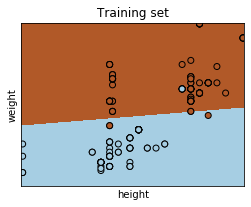

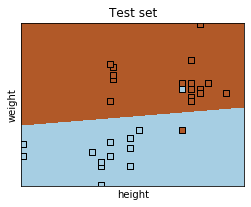

In [19]:
# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].

# NOTICE: This visualization code has been developed for a "standard" solution of the notebook, 
# it could be necessary to make some fixes to adapt to your implementation

h = .02  # step size in the mesh
x_min, x_max = X_reduced[:, 0].min() - .5, X_reduced[:, 0].max() + .5
y_min, y_max = X_reduced[:, 1].min() - .5, X_reduced[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

Z = logreg_2feat.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)

plt.figure(1, figsize=(4, 3))
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

# Plot also the training points
plt.scatter(X_training[:, 0], X_training[:, 1], c=Y_training, edgecolors='k', cmap=plt.cm.Paired)
plt.xlabel(feature_name0)
plt.ylabel(feature_name1)

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())
plt.title('Training set')

plt.show()

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(4, 3))
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

# Plot also the test points 
plt.scatter(X_test[:, 0], X_test[:, 1], c=Y_test, edgecolors='k', cmap=plt.cm.Paired, marker='s')
plt.xlabel(feature_name0)
plt.ylabel(feature_name1)

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())
plt.title('Test set')

plt.show()